<a href="https://colab.research.google.com/github/sine2pi/embedding-functions/blob/main/functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Input to rotate_half: tensor([1., 2., 3., 4.])
Output of rotate_half: tensor([-2.,  1., -4.,  3.])
Input to fourier_encode: tensor([1., 2., 3.])
Output of fourier_encode:
 tensor([[ 1.3511e-06, -8.6603e-01,  8.6602e-01,  2.7021e-06,  1.0000e+00,
         -5.0000e-01, -5.0000e-01,  1.0000e+00],
        [ 2.7021e-06,  8.6603e-01, -8.6603e-01,  5.4043e-06,  1.0000e+00,
         -5.0000e-01, -5.0000e-01,  1.0000e+00],
        [ 2.3850e-07,  5.4043e-06,  2.9406e-06,  4.7700e-07,  1.0000e+00,
          1.0000e+00,  1.0000e+00,  1.0000e+00]])
Rotated Tensor (apply_learned_rotations): tensor([[ 0.6816,  0.5253,  0.8482,  0.7851,  0.5471,  1.0729, -0.2707,  0.8091,
          0.2547,  0.2702,  0.6443,  0.7105],
        [-0.1364,  0.8823, -0.3701,  0.9372,  0.7716,  0.5993,  0.1173,  0.1332,
         -0.0932,  0.7513, -0.1083,  0.5681],
        [-0.3157,  0.7080, -0.7419,  0.5197,  0.5882,  0.3977,  0.8611,  0.4237,
          0.5431,  0.6587,  0.8050,  0.9719],
        [-0.0260,  0.6756,  0.0537,

<ipython-input-1-2ca2c31bb12e>:66: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:62.)
  x_rot = x + 2 * (q[0] * torch.cross(u.unsqueeze(0), x) + torch.cross(u.unsqueeze(0), torch.cross(u.unsqueeze(0), x)))


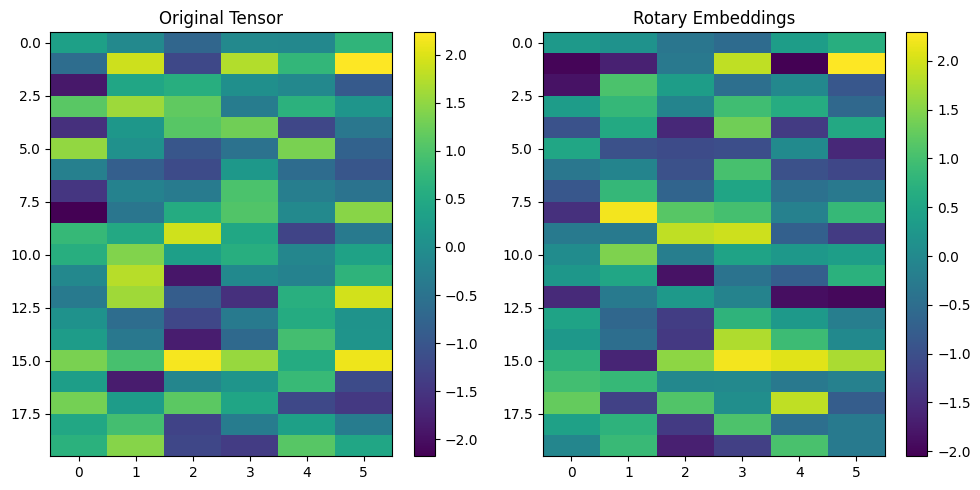

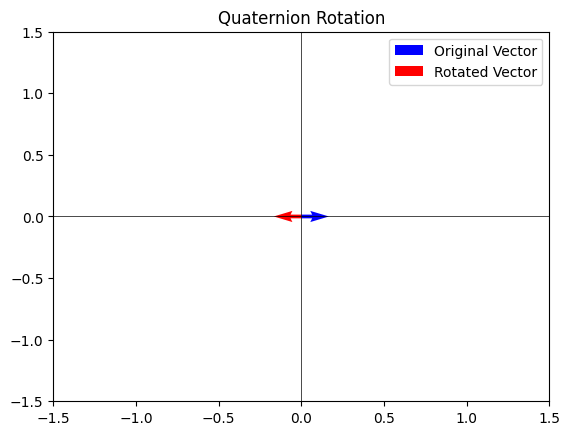

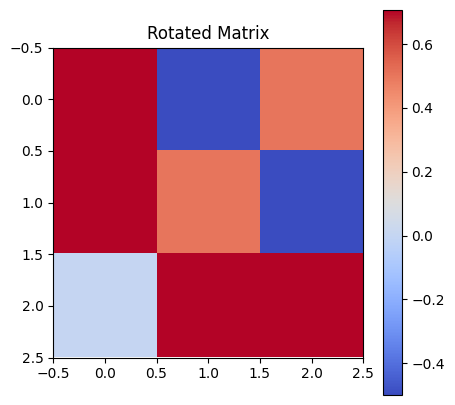

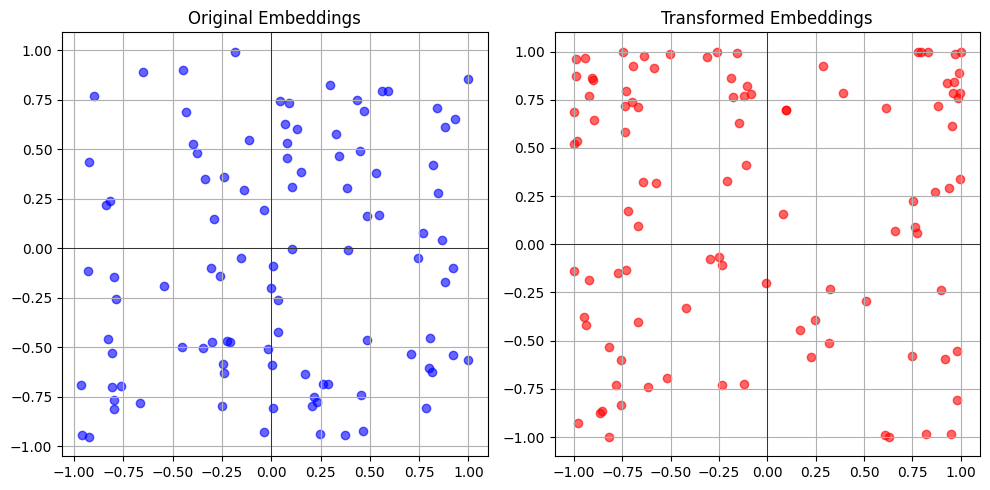

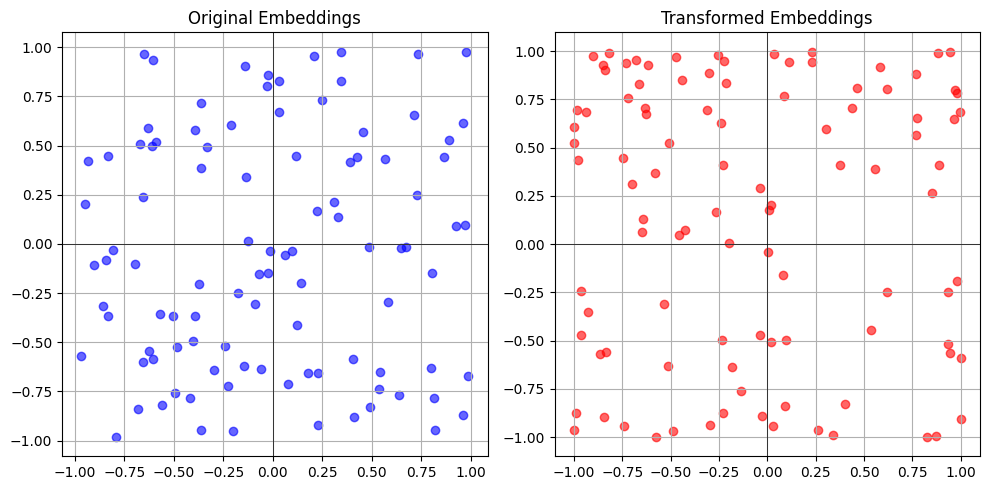

In [ ]:
import torch
from einops import rearrange, repeat
from torch import einsum
import matplotlib.pyplot as plt
from math import pi

# Define the functions
def rotate_half(x):
    x = rearrange(x, '... (d r) -> ... d r', r = 2)
    x1, x2 = x.unbind(dim = -1)
    x = torch.stack((-x2, x1), dim = -1)
    return rearrange(x, '... d r -> ... (d r)')

def fourier_encode(x, max_freq, num_bands=4, base=2):
    x = x.unsqueeze(-1) * torch.linspace(1., base, num_bands, device=x.device)
    x = x * pi * max_freq
    x = torch.cat((x.sin(), x.cos()), dim=-1)
    return x

# Test for rotate_half
x_rotate = torch.tensor([1.0, 2.0, 3.0, 4.0])
rotated = rotate_half(x_rotate)
print("Input to rotate_half:", x_rotate)
print("Output of rotate_half:", rotated)

# Test for fourier_encode
x_fourier = torch.tensor([1.0, 2.0, 3.0])
max_freq = 10.0
num_bands = 4
encoded = fourier_encode(x_fourier, max_freq, num_bands)
print("Input to fourier_encode:", x_fourier)
print("Output of fourier_encode:\n", encoded)

def y(val):
    return val is not None

def default(val, d):
    return val if y(val=val) else d

def y(x):
    return x is not None

def slice_at_dim(t, dim_slice: slice, *, dim):
    dim += (t.ndim if dim < 0 else 0)
    colons = [slice(None)] * t.ndim
    colons[dim] = dim_slice
    return t[tuple(colons)]


def apply_learned_rotations(rotations, t, start_index=0, freq_ranges=None):
    if freq_ranges is not None:
        rotations = einsum('..., f -> ... f', rotations, freq_ranges)
        rotations = rearrange(rotations, '... r f -> ... (r f)')
    rotations = repeat(rotations, '... n -> ... (n r)', r=2)
    return apply_rotary_emb(rotations, t, start_index=start_index)

def q_rotation(s, x, theta, u, v):
    x = x
    theta = theta if isinstance(theta, (int, float)) else theta
    u, v = u, v
    u, v = u / torch.norm(u), v / torch.norm(v)
    half_theta = theta / 2
    cos_ht, sin_ht = torch.cos(half_theta), torch.sin(half_theta)
    q = torch.cat([cos_ht.unsqueeze(0), sin_ht * u])
    x_rot = x + 2 * (q[0] * torch.cross(u.unsqueeze(0), x) + torch.cross(u.unsqueeze(0), torch.cross(u.unsqueeze(0), x)))
    return x_rot

def rotation_matrix(s, dims, i, j, theta):
    G = torch.eye(dims, device=s.device)
    c, s_ = torch.cos(theta), torch.sin(theta)
    G[i, i], G[j, j] = c, c
    G[i, j], G[j, i] = -s_, s_
    return G

def rotate(s, x):
    for k in range(int(torch.round(s.rscale * s.rot))):
        i, j = s.r_pairs[k].long()
        theta = s.thetas[k] * s.tscale
        G = rotation_matrix(s, dims=x.size(-1), i=i.item(), j=j.item(), theta=theta)
        x = x @ G
    return x

def apply_rotary_emb(
    freqs,t, start_index = 0, scale = 1., seq_dim = -2, freqs_seq_dim = None):
    dtype = t.dtype
    if not y(freqs_seq_dim):
        if freqs.ndim == 2 or t.ndim == 3:
            freqs_seq_dim = 0

    if t.ndim == 3 or y(freqs_seq_dim):
        ctx = t.shape[seq_dim]
        freqs = slice_at_dim(freqs, slice(-ctx, None), dim = freqs_seq_dim)

    rot_dim = freqs.shape[-1]
    end_index = start_index + rot_dim
    assert rot_dim <= t.shape[-1], f'feature dimension {t.shape[-1]} is not of sufficient size to rotate in all the positions {rot_dim}'
    t_left = t[..., :start_index]
    t_middle = t[..., start_index:end_index]
    t_right = t[..., end_index:]
    t_transformed = (t_middle * freqs.cos() * scale) + (rotate_half(t_middle) * freqs.sin() * scale)
    out = torch.cat((t_left, t_transformed, t_right), dim=-1)
    return out.type(dtype)

# Visualization for `apply_learned_rotations`
rotations = torch.rand(6, 6)  # Example rotation tensor
t = torch.rand(6, 12)  # Example tensor for `t`
rotated_t = apply_learned_rotations(rotations, t)
print("Rotated Tensor (apply_learned_rotations):", rotated_t)

# Visualization for `q_rotation`
s = torch  # Using torch here as a mock for `s`
x = torch.tensor([[1.0, 0.0, 0.0]])
theta = torch.tensor(3.14159 / 2)  # Rotate by 90 degrees
u = torch.tensor([0.0, 0.0, 1.0])
v = torch.tensor([1.0, 0.0, 0.0])
rotated_x = q_rotation(s, x, theta, u, v)
print("Rotated Vector (q_rotation):", rotated_x)

# Visualization for `rotate`
class State:
    def __init__(self, rscale, rot, r_pairs, thetas, tscale, head_dim):
        self.rscale = rscale
        self.rot = rot
        self.r_pairs = r_pairs
        self.thetas = thetas
        self.tscale = tscale
        self.head_dim = head_dim
        self.device = torch.device('cpu')

s = State(rscale=1.0, rot=torch.tensor(2.0),
          r_pairs=torch.tensor([[0, 1], [1, 2]]),
          thetas=torch.tensor([3.14159 / 4, 3.14159 / 4]),
          tscale=1.0, head_dim=3)
x = torch.eye(3)
rotated = rotate(s, x)
print("Rotated Matrix (rotate):", rotated)

# Define all helper functions
def rotate_half(x):
    x = rearrange(x, '... (d r) -> ... d r', r=2)
    x1, x2 = x.unbind(dim=-1)
    x = torch.stack((-x2, x1), dim=-1)
    return rearrange(x, '... d r -> ... (d r)')

def y(val):
    return val is not None

def default(val, d):
    return val if y(val=val) else d

def slice_at_dim(t, dim_slice: slice, *, dim):
    dim += (t.ndim if dim < 0 else 0)
    colons = [slice(None)] * t.ndim
    colons[dim] = dim_slice
    return t[tuple(colons)]

def apply_rotary_emb(freqs, t, start_index=0, scale=1.0, seq_dim=-2, freqs_seq_dim=None):
    dtype = t.dtype
    if not y(freqs_seq_dim):
        if freqs.ndim == 2 or t.ndim == 3:
            freqs_seq_dim = 0

    if t.ndim == 3 or y(freqs_seq_dim):
        ctx = t.shape[seq_dim]
        freqs = slice_at_dim(freqs, slice(-ctx, None), dim=freqs_seq_dim)

    rot_dim = freqs.shape[-1]
    end_index = start_index + rot_dim
    t_left = t[..., :start_index]
    t_middle = t[..., start_index:end_index]
    t_right = t[..., end_index:]
    t_transformed = (t_middle * freqs.cos() * scale) + (rotate_half(t_middle) * freqs.sin() * scale)
    return torch.cat((t_left, t_transformed, t_right), dim=-1).type(dtype)

# Visualization for apply_rotary_emb
def visualize_apply_rotary_emb():
    seq_len, feature_dim = 20, 6
    t = torch.randn(seq_len, feature_dim)
    freqs = torch.randn(seq_len, feature_dim)
    transformed = apply_rotary_emb(freqs, t)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Tensor")
    plt.imshow(t, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title("Rotary Embeddings")
    plt.imshow(transformed, aspect='auto', cmap='viridis')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

# Test q_rotation visualization
def visualize_q_rotation():
    s = torch  # Mocking 's' as torch
    x = torch.tensor([[10.0, 0.0, 0.0]])
    theta = torch.tensor(pi / 2)  # 90 degrees rotation
    u = torch.tensor([0.0, 1780.0, 1.0])  # Rotation axis
    v = torch.tensor([1.0, 0.0, 1440.0])

    rotated_x = q_rotation(s=s, x=x, theta=theta, u=u, v=v)
    # Visualize input and output
    plt.figure()
    plt.quiver([0], [0], x[0, 0], x[0, 1], angles='xy', scale_units='xy', color='blue', label='Original Vector')
    plt.quiver([0], [0], rotated_x[0, 0], rotated_x[0, 1], angles='xy', scale_units='xy', color='red', label='Rotated Vector')
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.legend()
    plt.title("Quaternion Rotation")
    plt.show()

# Visualize rotation matrix
def visualize_rotation_matrix():
    class State:
        def __init__(self, rscale, rot, r_pairs, thetas, tscale, head_dim):
            self.rscale = rscale
            self.rot = rot
            self.r_pairs = r_pairs
            self.thetas = thetas
            self.tscale = tscale
            self.head_dim = head_dim
            self.device = torch.device('cpu')

    s = State(rscale=1.0, rot=torch.tensor(2.0),
              r_pairs=torch.tensor([[0, 1], [1, 2]]),
              thetas=torch.tensor([pi / 4, pi / 4]),
              tscale=1.0, head_dim=3)

    x = torch.eye(3)
    rotated = rotate(s, x)

    plt.figure(figsize=(5, 5))
    plt.imshow(rotated, cmap='coolwarm', aspect='equal')
    plt.colorbar()
    plt.title("Rotated Matrix")
    plt.show()

# Run the visualizations
visualize_apply_rotary_emb()
visualize_q_rotation()
visualize_rotation_matrix()

# Helper function: Rotate by 90 degrees
def rotate_half(x):
    x = rearrange(x, '... (d r) -> ... d r', r=2)
    x1, x2 = x.unbind(dim=-1)
    x = torch.stack((-x2, x1), dim=-1)
    return rearrange(x, '... d r -> ... (d r)')

# Create synthetic embeddings
def create_embeddings(num_points=100, dim=2):
    return torch.rand(num_points, dim) * 2 - 1  # Random values in [-1, 1]

# Apply amplitude scaling
def apply_amplitude_scaling(x, scale_factor=2.0):
    scaling = torch.rand_like(x) * scale_factor
    return x * scaling

# Add Fourier phase shifts
def add_fourier_phase_shifts(x, freq=3.0, phase_shift=pi / 4):
    phase = freq * x + phase_shift
    return torch.sin(phase), torch.cos(phase)

# Combine transformations
def transform_embeddings(x):
    # Amplitude scaling
    scaled = apply_amplitude_scaling(x)

    # Fourier transformations
    sin_wave, cos_wave = add_fourier_phase_shifts(scaled)

    # Combine sine and cosine waves
    fourier_embedding = torch.cat([sin_wave, cos_wave], dim=-1)

    # Apply rotation
    rotated = rotate_half(fourier_embedding)
    return rotated

# Visualize the transformed embeddings
def visualize_embeddings(original, transformed):
    plt.figure(figsize=(10, 5))

    # Original embeddings
    plt.subplot(1, 2, 1)
    plt.title("Original Embeddings")
    plt.scatter(original[:, 0], original[:, 1], c='blue', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    # Transformed embeddings
    plt.subplot(1, 2, 2)
    plt.title("Transformed Embeddings")
    plt.scatter(transformed[:, 0], transformed[:, 1], c='red', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Test the transformations
original_embeddings = create_embeddings()
transformed_embeddings = transform_embeddings(original_embeddings)
visualize_embeddings(original_embeddings, transformed_embeddings)

# Helper function: Rotate by 90 degrees
def rotate_half(x):
    x = rearrange(x, '... (d r) -> ... d r', r=2)
    x1, x2 = x.unbind(dim=-1)
    x = torch.stack((-x2, x1), dim=-1)
    return rearrange(x, '... d r -> ... (d r)')

# Create synthetic embeddings
def create_embeddings(num_points=100, dim=2):
    return torch.rand(num_points, dim) * 2 - 1  # Random values in [-1, 1]

# Apply amplitude scaling
def apply_amplitude_scaling(x, scale_factor=2.0):
    scaling = torch.rand_like(x) * scale_factor
    return x * scaling

# Add Fourier phase shifts
def add_fourier_phase_shifts(x, freq=3.0, phase_shift=pi / 4):
    phase = freq * x + phase_shift
    return torch.sin(phase), torch.cos(phase)

# Combine transformations
def transform_embeddings(x):
    # Amplitude scaling
    scaled = apply_amplitude_scaling(x)

    # Fourier transformations
    sin_wave, cos_wave = add_fourier_phase_shifts(scaled)

    # Combine sine and cosine waves
    fourier_embedding = torch.cat([sin_wave, cos_wave], dim=-1)

    # Apply rotation
    rotated = rotate_half(fourier_embedding)

    return rotated

# Visualize the transformed embeddings
def visualize_embeddings(original, transformed):
    plt.figure(figsize=(10, 5))

    # Original embeddings
    plt.subplot(1, 2, 1)
    plt.title("Original Embeddings")
    plt.scatter(original[:, 0], original[:, 1], c='blue', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    # Transformed embeddings
    plt.subplot(1, 2, 2)
    plt.title("Transformed Embeddings")
    plt.scatter(transformed[:, 0], transformed[:, 1], c='red', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Test the transformations
original_embeddings = create_embeddings()
transformed_embeddings = transform_embeddings(original_embeddings)
visualize_embeddings(original_embeddings, transformed_embeddings)